In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Import libraries from outside folder
import sys
sys.path.append('../lib/')

from opencv_lib import cvWriter

# Plan

1. All EXC form 2D regular grid
    * connected by a radial gaussian weight kernel
2. All INH are 1-to-1 with EXC
    * INH superlinear to kill off wave
    * INH response a bit slow to allow wave to propagate
3. For most basic setup use rate neurons

$ \tau^{EXC} \dot{x}_i^{EXC} = -x_i^{EXC} - W_i^{IE} x_i^{INH} + W_{ij}^{EE} x_j^{EXC} $

$ \tau^{INH} \dot{x}_i^{INH} = -x_i^{INH} + W_i^{EI} x_i^{EXC} $


In [3]:
class NearestNeighborDevice:
    def __init__(self, p):
        self.p = p
        self.p["ALPHA_EXC"] = p["DT"] / p["TAU_EXC"]
        self.p["ALPHA_INH"] = p["DT"] / p["TAU_INH"]
        self.sh = (p["GRID_NX"], p["GRID_NY"])
        self.coords = np.array([
            np.outer(np.arange(self.sh[0]), np.ones(self.sh[1])).flatten(),
            np.outer(np.ones(self.sh[0]), np.arange(self.sh[1])).flatten()
        ]).T
        self._gau_conn_2D(self.coords)
        self.thr = np.ones(self.sh).flatten()

    def _add_dim(self, vec, nDimFinal, axis=0):
        newShape = [1]*nDimFinal
        newShape[axis] = vec.shape[0]
        return vec.reshape(tuple(newShape))

    def _gau_nd(self, x, mu, s2):
        muEff = self._add_dim(mu, x.ndim, axis=1)
        s2Eff = self._add_dim(s2, x.ndim, axis=1)
        chi2 = np.sum( (x - muEff)**2 / (2*s2Eff), axis=1 )
        return np.exp(-chi2) / np.prod(np.sqrt(2 * np.pi * s2))

    def _gau_conn_2D(self, coords):
        self.mEEIdxs = []
        self.mEEWeights = []
        
        coordIdxs = np.arange(len(coords))
        var2d = np.array([self.p["CONN_GAU_VAR"]]*2)
        for iCoord in coordIdxs:
            weights = self._gau_nd(coords, coords[iCoord], var2d)
            weights *= self.p["W0_EXC"]
            idxHighWeight = weights > self.p["CONN_MAG_THR"] * np.max(weights)
            idxNotSelf = coordIdxs != iCoord
            weightIdxs = np.where(idxHighWeight & idxNotSelf)[0]
            
            self.mEEIdxs += [coordIdxs[weightIdxs]]
            self.mEEWeights += [weights[weightIdxs]]
    
    def _sparse_mv(self, x, idxLst, weightLst):
        return np.array([np.dot(x[idxs], weights) for idxs, weights in zip(idxLst, weightLst)])
    
    def get_weight_by_idx(self, idxX, idxY):
        idx = idxX * self.sh[1] + idxY
        
        connStrThis = np.full(np.prod(self.sh), np.nan)
        connStrThis[self.mEEIdxs[idx]] = self.mEEWeights[idx]
        
        return connStrThis.reshape(self.sh)
        
    def set_threshold_map(self, thr):
        self.thr = thr
        
    def update(self, xExc, xInh):
        aExc = self.p["ALPHA_EXC"]
        aInh = self.p["ALPHA_INH"]
        wInh = self.p["W0_INH"]
        
        feedbackEE = self._sparse_mv(xExc, self.mEEIdxs, self.mEEWeights)
        feedbackE = (-wInh * xInh + feedbackEE) / self.thr
        
        xExcNew = (1-aExc) * xExc + aExc*feedbackE
        xInhNew = (1-aInh) * xInh + aInh*(xExc**2)
        return np.clip(xExcNew, 0, 1), xInhNew
        

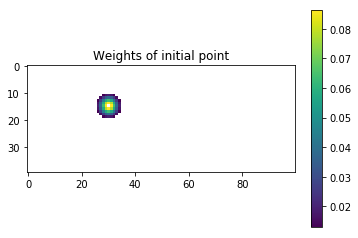

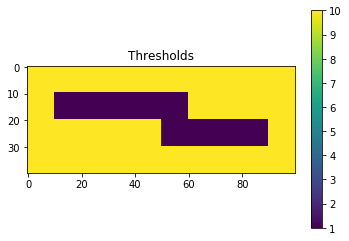

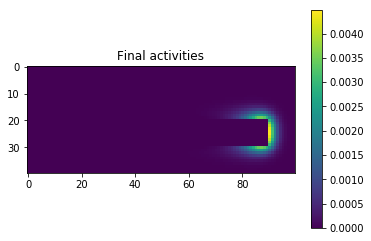

In [5]:
def plot_mat(m, title):
    plt.figure()
    plt.imshow(m.T)
    plt.colorbar()
    plt.title(title)

param = {
    "GRID_NX" : 100,
    "GRID_NY" : 40,
    "GRID_LENGTHSCALE" : 1.0,
    "CONN_GAU_VAR" : 5.0,
    "CONN_MAG_THR" : 0.1,
    "DT"           : 0.1,       # ms, timescale
    "TAU_EXC"      : 1,         # ms, excitatory timescale
    "TAU_INH"      : 2,         # ms, inhibitory timescale
    "W0_EXC"       : 3.0,       # mV, excitatory weight scale
    "W0_INH"       : 6.0        # mV, inhibitory weight scale
}

NND = NearestNeighborDevice(param)

plot_mat(NND.get_weight_by_idx(30, 15), "Weights of initial point")


###############################
# Produce fancy thresholds
###############################
# thresholds = np.full(NND.sh, 1)
thresholds = np.full(NND.sh, 10)
# thresholds = np.full(NND.sh, 1)
thresholds[10:50, 10:20] = 1
thresholds[50:60, 10:30] = 1
thresholds[60:90, 20:30] = 1
NND.set_threshold_map(thresholds.flatten())

plot_mat(thresholds, "Thresholds")

###############################
# Run simulation and write video
###############################

xExc = np.zeros(NND.sh).flatten()
xInh = np.zeros(NND.sh).flatten()
xExc[30 * 40 + 15] = 1

nTime = 200

with cvWriter("testvid.avi", NND.sh[::-1], frate=30.0) as vidWriter:
    for iTime in range(nTime):
        xExc, xInh = NND.update(xExc, xInh)
        vidWriter.write(255 * xExc.reshape(NND.sh).T)
        
###############################
# Plot final state
###############################
        
plot_mat(xExc.reshape(NND.sh), "Final activities")